In [41]:
import torch
from torch import nn
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from tqdm import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from sklearn.metrics import confusion_matrix
from fastprogress.fastprogress import master_bar



In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
import matplotlib.pyplot as plt

def plot_results(train_losses, valid_losses, train_correct, valid_correct, epochs, trainLoader, validLoader):
    # Convert losses from tensors to floats (if needed)
    train_losses = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
    valid_losses = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in valid_losses]

    # Convert correct counts to accuracy percentages
    train_acc = [(correct.cpu().item() if torch.is_tensor(correct) else correct) / len(trainLoader.dataset) * 100 for correct in train_correct]
    valid_acc = [(correct.cpu().item() if torch.is_tensor(correct) else correct) / len(validLoader.dataset) * 100 for correct in valid_correct]

    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(12, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, valid_losses, label="Valid Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_acc, label="Train Accuracy")
    plt.plot(epochs_range, valid_acc, label="Valid Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [44]:
from fastprogress.fastprogress import master_bar, progress_bar
import matplotlib.pyplot as plt
import time

def runModel(train_loader, valid_loader, test_loader, epochs, model, criterion):

    optimizer = torch.optim.Adam(model.parameters(), lr=.001)
    # A master bar for fancy output progress
    mb = master_bar(range(epochs))

    # # Information for plots
    mb.names = ["Train Loss", "Valid Loss"]
    train_losses = []
    valid_losses = []

    train_correct = []
    valid_correct = []

    start_time = time.time()

    for epoch in mb:

        model.train()

        # train_N = len(train_loader.dataset)
        # num_train_batches = len(train_loader)
        # train_dataiterator = iter(train_loader)

        # train_loss_mean = 0

        trn_corr = 0
        valid_corr = 0

        train_loss = 0
        valid_loss = 0

        #train
        for b, (X_train, y_train) in enumerate(tqdm.tqdm(train_loader)):
            X_train, y_train = X_train.to(device), y_train.to(device)
            b+=1
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            train_loss += loss.item()

            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_train).sum()
            trn_corr += batch_corr
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_losses.append(train_loss / len(train_loader)) # average accumulated loss per batch
        train_correct.append(trn_corr)
        
        #validation
        model.eval()
        with torch.no_grad():
            for b, (X_valid, y_valid) in enumerate(tqdm.tqdm(valid_loader)):
                X_valid, y_valid = X_valid.to(device), y_valid.to(device)
                y_value = model(X_valid)
                predicted = torch.max(y_value.data, 1)[1]
                valid_corr += (predicted == y_valid).sum()
        
                loss = criterion(y_value, y_valid)
                valid_loss += loss.item()

        valid_losses.append(valid_loss / len(valid_loader))
        valid_correct.append(valid_corr)

        mb.write(f"[{epoch+1}/{epochs}] train loss = {train_losses[epoch]:.4f}; train accuracy = {trn_corr / len(train_loader.dataset) * 100}; valid loss = {valid_losses[epoch]:.4f}; valid accuracy = {valid_corr / len(valid_loader.dataset) * 100}") 

    current_time = time.time()
    total = current_time - start_time
    print(f'Training Took: {(total/60):.2f} minutes!')

        
    plot_results(train_losses, valid_losses, train_correct, valid_correct, epochs, train_loader, valid_loader)

    model.eval()

    all_preds = []
    all_labels = []
    # Test
    # test_losses = []
    test_loss = 0
    test_corr = 0
    # test_correct = []

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(tqdm.tqdm(test_loader)):
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            
            y_value = model(X_test)
            predicted = torch.max(y_value.data, 1)[1]
            test_corr += (predicted == y_test).sum()

            loss = criterion(y_value, y_test)
            test_loss += loss.item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_test.cpu().numpy())
    # test_losses.append(loss)
    # test_correct.append(test_corr)

    print(f"avg test loss = {test_loss / len(test_loader):.4f}; test accuracy = {test_corr / len(test_loader.dataset)}") # ADD Accuracy

    cm = confusion_matrix(all_labels, all_preds)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalize

    plt.imshow(cm, cmap='Blues')
    plt.title('Confusion Matrix (Normalized)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    plt.xticks(np.arange(10), labels, rotation=45, ha="right")
    plt.yticks(np.arange(10), labels)

    for i in range(10):
        for j in range(10):
            plt.text(j, i, f"{cm[i, j]:.2f}", ha='center', va='center', color='black')

    plt.colorbar()
    plt.tight_layout()
    plt.show()

    # plot_results(train_losses, valid_losses, train_correct, valid_correct, epochs=epochs)

In [45]:
# Load data
CaiT_transforms = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),  # Keeps it as [1, 28, 28]
])

torch.manual_seed(47)

CaiT_dataset = FashionMNIST(root="./data", train=True, download=True, transform=CaiT_transforms)
CaiT_test_dataset = FashionMNIST(root="./data", train=False, download=True, transform=CaiT_transforms)

train_size = int(0.9 * len(CaiT_dataset))
val_size = len(CaiT_dataset) - train_size
CaiT_train_dataset, CaiT_valid_dataset = random_split(CaiT_dataset, [train_size, val_size])
batch_size = 256

CaiTTrainLoader = DataLoader(CaiT_train_dataset, batch_size=256,
                                          shuffle=True)
CaiTValidLoader = DataLoader(CaiT_valid_dataset, batch_size=256,
                                          shuffle=False)
CaiTTestLoader = DataLoader(CaiT_test_dataset, batch_size=256,
                                          shuffle=False)

In [46]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=28, patch_size=4, in_channels=1, embed_dim=64):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
    def forward(self, x):
        x = self.proj(x)
        return x.flatten(2).transpose(1, 2)

class LayerScaleBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1, layer_scale_init=1e-5):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.gamma_1 = nn.Parameter(layer_scale_init * torch.ones(embed_dim))
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.gamma_2 = nn.Parameter(layer_scale_init * torch.ones(embed_dim))

    def forward(self, x):
        x = x + self.gamma_1 * self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.gamma_2 * self.mlp(self.norm2(x))
        return x

class ClassAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1, layer_scale_init=1e-5):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.gamma_1 = nn.Parameter(layer_scale_init * torch.ones(embed_dim))
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(dropout)
        )
        self.gamma_2 = nn.Parameter(layer_scale_init * torch.ones(embed_dim))

    def forward(self, cls_token, x):
        cls_token = cls_token + self.gamma_1 * self.attn(self.norm1(cls_token), self.norm1(x), self.norm1(x))[0]
        cls_token = cls_token + self.gamma_2 * self.mlp(self.norm2(cls_token))
        return cls_token

class CaiT_Lite(nn.Module):
    def __init__(self, img_size=28, patch_size=4, in_channels=1, num_classes=10,
                 embed_dim=64, depth=4, class_depth=2, num_heads=4, mlp_dim=128, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, (img_size // patch_size)**2, embed_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.cls_pos = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.dropout = nn.Dropout(dropout)

        self.blocks = nn.Sequential(*[
            LayerScaleBlock(embed_dim, num_heads, mlp_dim, dropout) for _ in range(depth)
        ])
        self.class_blocks = nn.ModuleList([
            ClassAttentionBlock(embed_dim, num_heads, dropout) for _ in range(class_depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x) + self.pos_embed
        x = self.dropout(x)
        x = self.blocks(x)

        cls_token = self.cls_token.expand(B, -1, -1) + self.cls_pos
        for blk in self.class_blocks:
            cls_token = blk(cls_token, x)

        cls_token = self.norm(cls_token)
        return self.head(cls_token[:, 0])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 41.92it/s]


Training Took: 1.53 minutes!


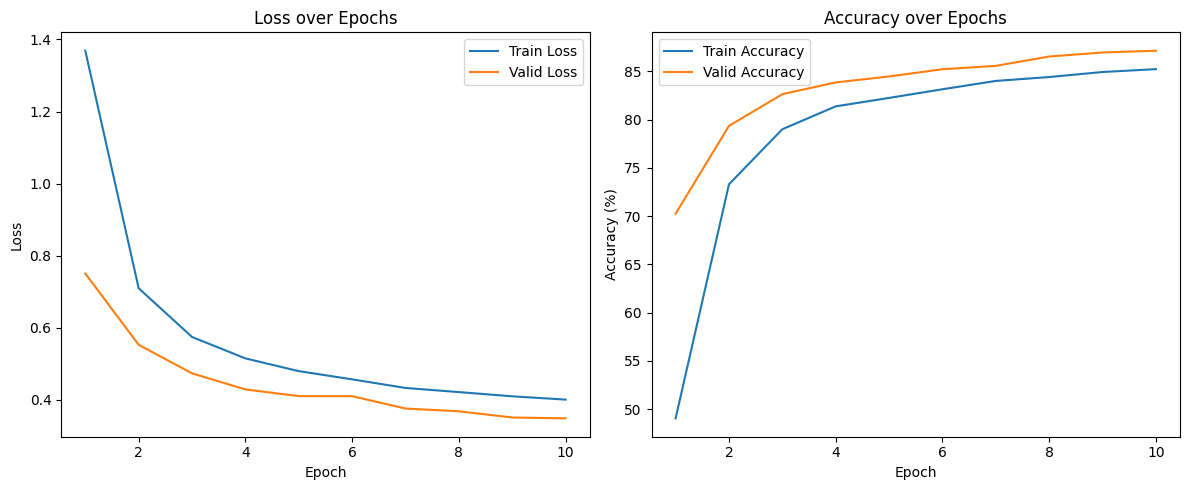

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 41.63it/s]


avg test loss = 0.3834; test accuracy = 0.8562999963760376


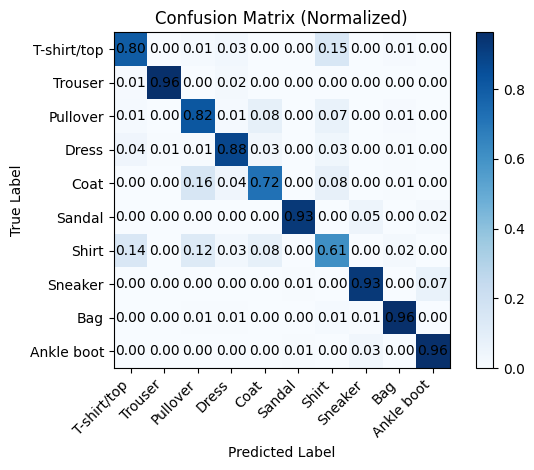

In [48]:
model = CaiT_Lite(
    img_size=28, 
    patch_size=4,
    in_channels=1,
    num_classes=10
).to(device)

criterion = nn.CrossEntropyLoss()

runModel(CaiTTrainLoader, CaiTValidLoader, CaiTTestLoader, epochs=10, model=model, criterion=criterion)